In [1]:
# imports
import sys; sys.path.insert(0, '..')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import trajectory_reconstruction_tradeoff as T
import random
import scanpy as sc
import warnings

warnings.filterwarnings('ignore')

random.seed(20)

In [2]:
# params
dirname = '../'
datadir = os.path.join(dirname, 'datasets' )
outdir = os.path.join(dirname, 'output')
save = False

# experiment params
exp_desc = 'reach_range' #'reach_uniform'# 
kwargs_traj = {}

# log version
# cell_fit = 'log pc' #'log nc'
cell_fit = 'log pc'
read_fit = 'log pt'# 'log nr'#

get_pc_min_pred = T.opt.get_pc_min_pred_log

read_title = lambda pt: r'$log(p_t)=$' + "{:.1f}".format(np.log(pt))
cell_title = lambda pc: r'$log(p_c)=$' + "{:.1f}".format(np.log(pc))

err_fit = 'l1' #'log l1' 

datasets = [
            # 'linear_rep0',
            # 'prosstt',
            # 'smprosstthayashi',
    
            'hayashi',
            'beta',
            'dendritic',
            'hepatoblast',
            'fibroblasts',
            'hematopoiesis',

            # 'marrow',
            # 'aging',
            # 'thymus',
            # 'embryos',
            # 'scvelo',
            # 'scvelo_pilot',
            # 'alpha',
            # 
            # 'kidney',
            # 'planaria',
            # 'astrocyte'
            ]

# datasets = ['hayashi', 'curve']

colors = T.pl.get_traj_colors(datasets)
colors = {k: 'lightslategray' for k in datasets}

## Datasets (FigS1)

In [3]:
# read datasets
trajs = {}

for dataset in datasets:
    
    X, _, meta, mn = T.io.read_dataset(dataset=dataset, dirname=datadir)
    trajs[dataset] = T.tr.Trajectory(X, meta=meta, milestone_network=mn, **kwargs_traj) 

ntrajs = len(trajs)

In [4]:
# preliminaries
plot_config, plot_loc = T.pl.get_plot_configs(datasets)

# generate palettes
palettes = T.pl.generate_palettes(trajs)

# fixing datanames
traj_fignames = T.pl.get_traj_fignames(datasets)

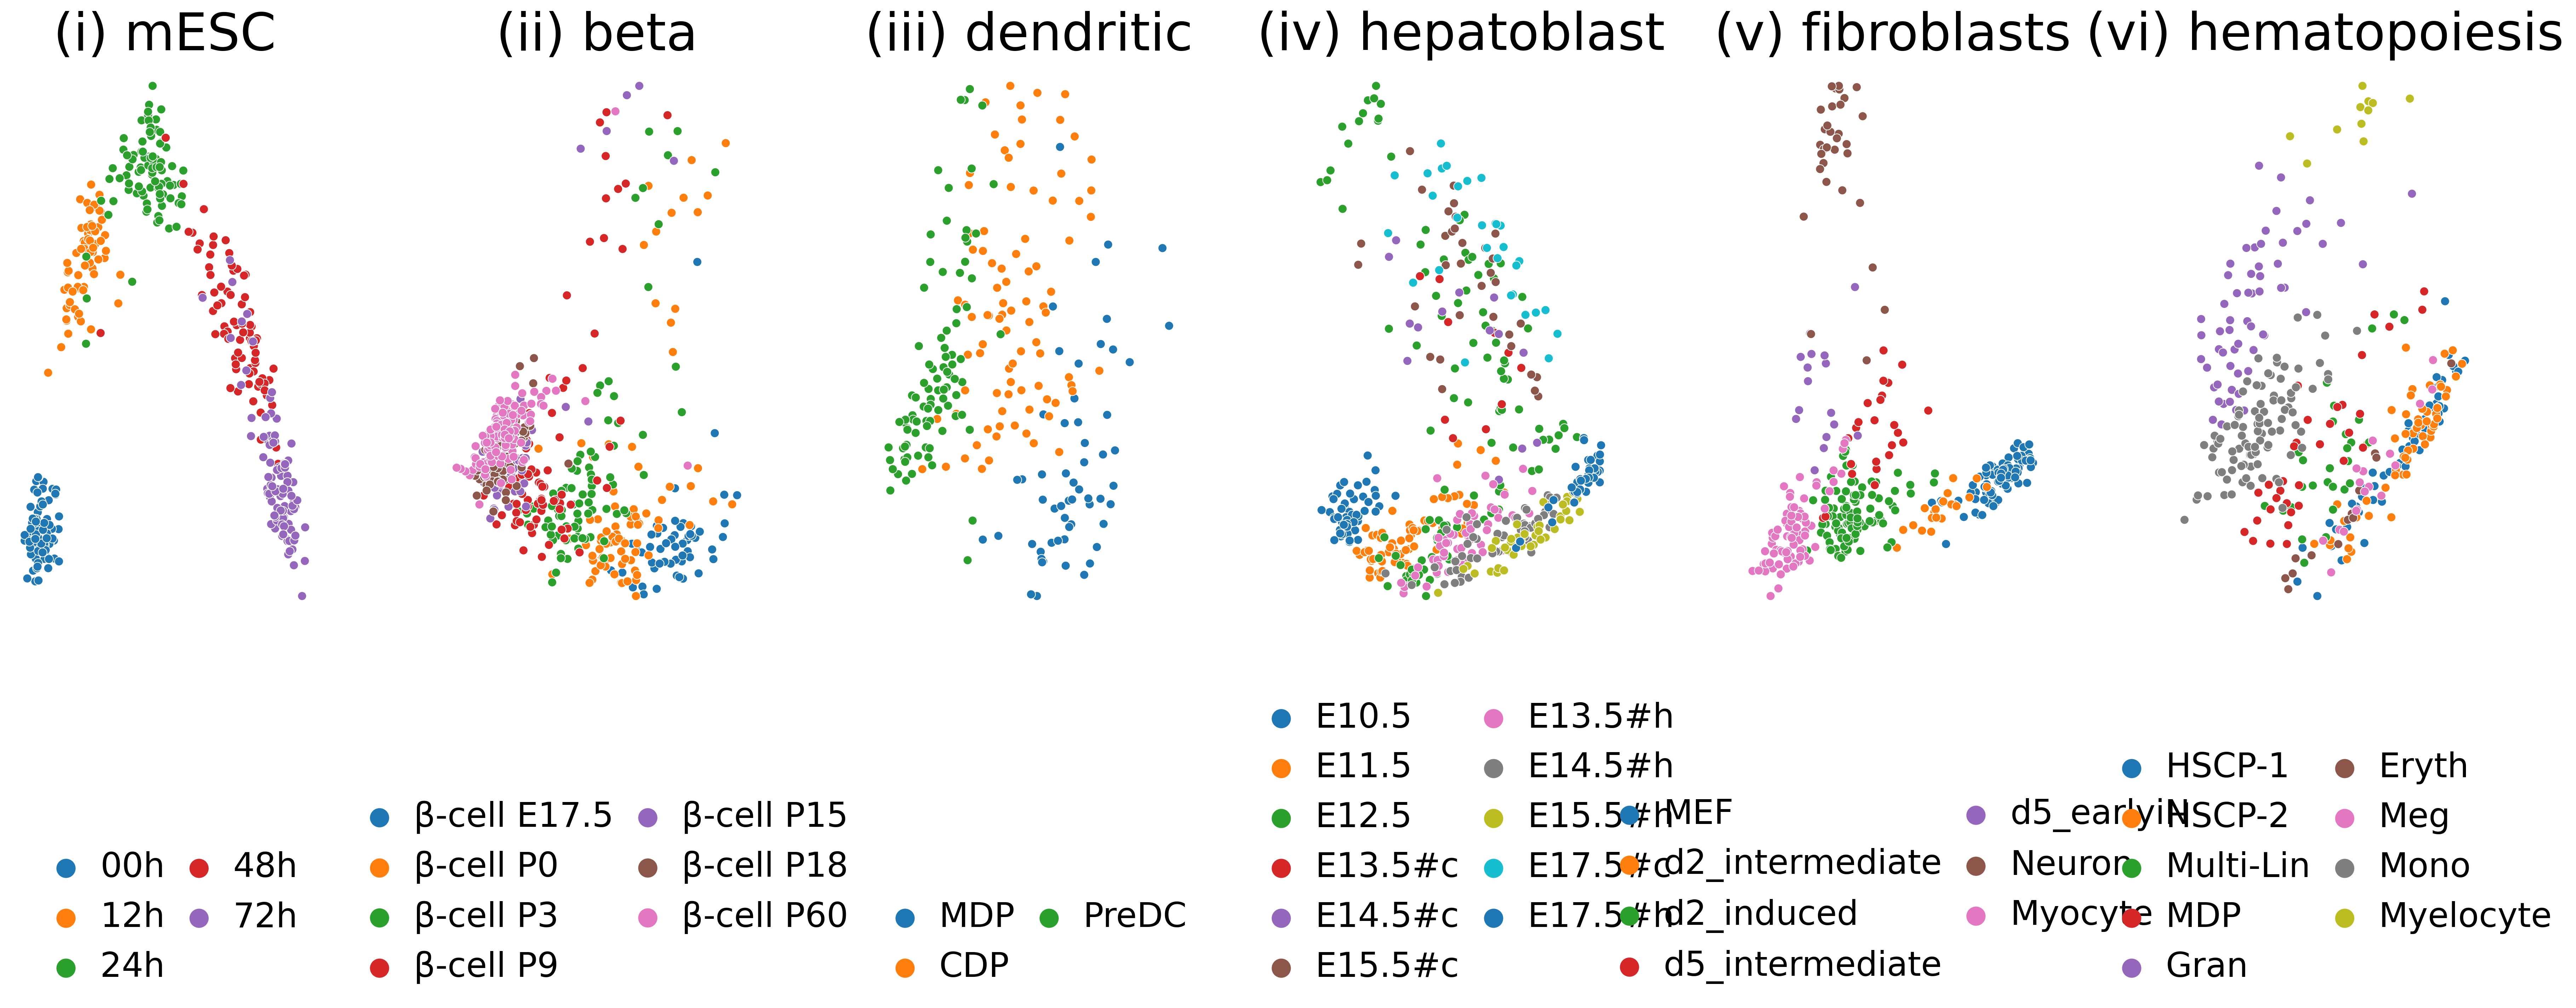

In [5]:
# plot trajectories

# for each, plot colored by branch and pseudotime (also distance from cell 0?)
plot_config2 = plot_config.copy()
plot_config2['figsize'] = (30, 7)

fig, ax = plt.subplots(**plot_config2)

# plot trajectories
for itraj, (traj_desc, traj) in enumerate(trajs.items()):
    title = f'({T.pl.write_roman(itraj + 1).lower()}) {traj_fignames[traj_desc]}'
    meta = traj.meta.copy()
    palette = palettes[traj_desc]
    if traj_desc == 'hepatoblast':
        shorten = {k:k.replace('hepatoblast/hepatocyte', 'h') for k in meta['milestone_id'].unique()}
        shorten = {k:v.replace('cholangiocyte', 'c') for k,v in shorten.items()}
        for k,v in shorten.items():
            palette[v] = palette[k]
        meta['milestone_id'] = meta['milestone_id'].map(lambda x: x.replace('hepatoblast/hepatocyte', 'h').replace('cholangiocyte', 'c'))
        # substiture 'hepatoblast/hepatocyte' with 'hepatocyte'
    T.pl.plot_project_pca2d(traj.pX, meta=meta, ax=ax[itraj], palette=palette, title=title, legendsize=35)
    
    pos = ax[itraj].get_position()
    ax[itraj].set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
    ax[itraj].legend(handletextpad=0.01,
                loc='lower center', 
                bbox_to_anchor=(0.5, -0.7),
                markerscale=2,
                ncol=2, fontsize=23, frameon=False, columnspacing=0)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
# plt.tight_layout()
if save:
    plt.savefig(os.path.join(outdir, 'fig_trajs.png'), bbox_inches='tight')

In [6]:
# stats
for traj_desc, traj in trajs.items():
    print(traj_desc)
    print(f'Num reads: {traj.X.sum().sum() / 10**6:.2f}M')
    print(f'Num cells: {traj.X.shape[0]}')
    print(f'Reads per cell: {traj.X.sum(axis=1).mean() / 10**3:.2f}k')

hayashi
Num reads: 101.46M
Num cells: 414
Reads per cell: 245.07k
beta
Num reads: 444.53M
Num cells: 562
Reads per cell: 790.99k
dendritic
Num reads: 70.62M
Num cells: 238
Reads per cell: 296.74k
hepatoblast
Num reads: 394.12M
Num cells: 504
Reads per cell: 781.98k
fibroblasts
Num reads: 47.57M
Num cells: 355
Reads per cell: 133.99k
hematopoiesis
Num reads: 137.18M
Num cells: 376
Reads per cell: 364.85k


In [7]:

# measures to plot
measure_titles = {
                'pt': r'$p_t$',
                'pc': r'$p_c$',                                
                'sqrt inv pt': r'$\frac{1}{\sqrt{p_t}}$', 
                'sqrt inv pc': r'$\frac{1}{\sqrt{p_c}}$',
                'l1': r'$\varepsilon$',
                'ldist': r'$\varepsilon^{dist}$',
                }


### Reads downsample (FigS2)
- example of downsample
- Delta(log p_t)
- dij(log p_t) (all?)
- l1(log p_t)

In [8]:
# read L_read
L_read_dict = T.io.read_output(datasets, outdir=outdir, sample='reads', exp_desc=exp_desc)
# min_log_pt = -8
# min_pt = 1e-6 # 3e-4 #
min_reads = 20 #100

for traj_desc, L_read in L_read_dict.items():
    print(traj_desc)
    min_pt  = min_reads / trajs[traj_desc].X.sum(1).mean()
    
    # L_read = L_read[L_read['log pt'] > min_log_pt]        
    L_read = L_read[L_read['pt'] > min_pt]       
    L_read['log nr'] = np.log(L_read['nr'])
    L_read['log l1'] = np.log(L_read['l1'])
    L_read_dict[traj_desc] = L_read
    print(L_read['pt'].min())
    print(L_read['pt'].max())
    # print(f'Pt range { L_read['pt'].min() } - { L_read['pt'].max() }')

hayashi
0.0001
0.5623413251903491
beta
3.1622776601683795e-05
0.1778279410038923
dendritic
0.0001
0.5623413251903491
hepatoblast
3.1622776601683795e-05
0.5623413251903491
fibroblasts
0.0001778279410038
0.5623413251903491
hematopoiesis
5.623413251903491e-05
0.5623413251903491


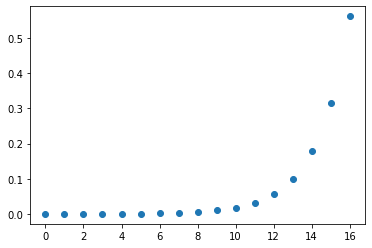

In [13]:
tmp = L_read['pt'].unique()
plt.scatter(range(tmp.shape[0]), tmp)

In [ ]:
# # plot measures
# traj_desc = 'hayashi'
# L_read = L_read_dict[traj_desc]
# traj = trajs[traj_desc]
# Pts = [1e-5, 4e-5, 1e-4, 1e-3]
# ncols = len(Pts)
# fig, ax = plt.subplots(1,ncols, figsize=(ncols * 5, 5))
# for ipt, pt in enumerate(Pts):
#     sX, psX, lsX, psD, sD, psP, ix, pca = traj.subsample(pc=1, pt=pt)
#     palette = palettes[traj_desc]
#     stitle = read_title(pt)
#     title = traj_fignames[traj_desc]
    
#     T.pl.plot_project_pca2d(psX, meta=traj.meta.loc[ix], ax=ax[ipt], title=stitle, legend=False, palette=palette)
#     print(f'pt: {pt:.2e}, mean reads: {sX.sum(1).mean():.2f}')
#     color = colors[traj_desc]

    

In [ ]:
# # 10 / traj.X.sum(1).mean()
# np.round(0.03 * 2 **np.arange(0,5,0.3), 2)

# 10** np.arange(-6, -0.5, 0.25)

In [ ]:
# Pc = np.round(0.03 * 2 **np.arange(0,7,0.1), 2) - 1
# Pc = Pc[Pc>0]
# Pc = Pc[Pc<0.9]
# Pc

In [ ]:
# Pt = np.round(10** np.arange(0.01, 0.55, 0.03) - 1,2)
# Pt = Pt[Pt>0]
# Pt = Pt[Pt<0.9]
# Pt

In [ ]:
# Pt = 10** np.arange(-6, -0.5, 0.25)
# min_reads = 20
# min_reads / traj.X.sum(1).mean()
# Pt < min_reads / traj.X.sum(1).mean()

In [ ]:
# plot measures
measure_titles['l1'] = r'$\varepsilon_t$'
measure_titles['ldist'] = r'$\varepsilon^{dist}_t$'
plot_std = 1

plot_descs = [ 
    {'xcol': read_fit, 'ycol': err_fit, 'add_fit': True, 'save_fit': True},
    ]


ntrajs_pl = 2
nfeatures =  ntrajs_pl + len(plot_descs)
fig, ax = plt.subplots(ntrajs, nfeatures, figsize=(6 * nfeatures, 6*ntrajs))
ax = ax.reshape((1,-1)) if len(ax.shape) == 1 else ax
# min_pt = 3e-4
groupby='pt'
# groupby = 'nr'
model_read_dict = {}
for itraj, (traj_desc, L_read) in enumerate(L_read_dict.items()):

    # plot trajectory
    pt = L_read['pt'].min()#[L_read['pt'] > min_pt]['pt'].min()
    # pt = L_read[L_read['log pt'] > min_log_pt]['pt'].min()
    traj = trajs[traj_desc]
    sX, psX, lsX, psD, sD, psP, ix, pca = traj.subsample(pc=1, pt=pt)
    palette = palettes[traj_desc]
    stitle = read_title(pt)
    title = traj_fignames[traj_desc]

    # if itraj == 0:
    #     title = f'({T.pl.write_roman(1).lower()}) {title}'
    #     stitle = f'({T.pl.write_roman(2).lower()}) {stitle}'
    T.pl.plot_project_pca2d(traj.pX, meta=traj.meta, ax=ax[itraj,0], title=title, legend=False, palette=palette) # true for subsample
    T.pl.plot_project_pca2d(psX, meta=traj.meta.loc[ix], ax=ax[itraj,1], title=stitle, legend=False, palette=palette)

    color = colors[traj_desc]

    for ipl, plot_desc in enumerate(plot_descs):
        
        sax = ax[itraj, ntrajs_pl + ipl]
        
        ycol= plot_desc['ycol']; 
        xcol = plot_desc['xcol']; 
        if (xcol in L_read.columns) and (ycol in L_read.columns):
            ylabel = measure_titles[ycol] if ycol in measure_titles.keys() else ycol
            xlabel = measure_titles[xcol] if xcol in measure_titles.keys() else xcol
            
            title = f'{ylabel} vs {xlabel}' if itraj == 0 else ''
            if itraj == 0:
                title = f'({T.pl.write_roman(3+ipl).lower()}) {title}'
            xlabel = xlabel if itraj == (ntrajs - 1) else ''
            
            add_fit = False if 'add_fit' not in plot_desc.keys() else plot_desc['add_fit']
            save_fit = False if 'save_fit' not in plot_desc.keys() else plot_desc['save_fit']
            
            model_read = T.pl.plot_tradeoff(L_read, xcol=xcol, ycol=ycol, ylabel=ylabel, xlabel=xlabel, plot_std=plot_std, ax=sax, color_mean=color, 
                                            color_std=color, title=title, groupby=groupby, add_fit=add_fit)

            ylim_bottom = None if 'ylim_bottom' not in plot_desc.keys() else plot_desc['ylim_bottom']
            ylim_top = None if 'ylim_top' not in plot_desc.keys() else plot_desc['ylim_top']
            sax.set_ylim(bottom=ylim_bottom, top=ylim_top)
            sax.set_xlim(right=0)
            
            if save_fit:
                model_read_dict[traj_desc] = model_read
                print(f'{traj_desc} a = {model_read.intercept_:.4f}, b = {model_read.coef_[0]:.4f}')
        
plt.tight_layout()

if save:
    plt.savefig(os.path.join(outdir, 'sfig_pt.png'))

## Cell downsample


In [ ]:
# read cell output
L_cell_dict = T.io.read_output(datasets, outdir=outdir, sample='cells', exp_desc=exp_desc)

# min_log_pc = -2
for traj_desc, L_cell in L_cell_dict.items():
    traj = trajs[traj_desc]
    L_cell['log l1'] = np.log(L_cell['l1'])    
    L_cell['log nc'] = np.log(L_cell['nc'])
    # L_cell = L_cell[L_cell['log pc'] > min_log_pc]
    L_cell_dict[traj_desc] = L_cell


In [ ]:
# plot measures
# cell_fit = r'$\zeta$'
measure_titles['l1'] = r'$\varepsilon_c$'
measure_titles['ldist'] = r'$\varepsilon^{dist}_c$'
plot_std = 1
model_type_cells = 'huber'
plot_descs = [ 
    {'xcol': cell_fit, 'ycol': err_fit, 'add_fit': True, 'save_fit': True},
    ]

ntrajs_pl = 2
nfeatures =  ntrajs_pl + len(plot_descs)
fig, ax = plt.subplots(ntrajs, nfeatures, figsize=(6 * nfeatures, 6*ntrajs))
ax = ax.reshape((1,-1)) if len(ax.shape) == 1 else ax

min_pc = 1e-1

groupby = 'pc'
# groupby = 'nc'
model_cell_dict = {}
for itraj, (traj_desc, L_cell) in enumerate(L_cell_dict.items()):

    # plot trajectory
    pc = L_cell[L_cell['pc'] > min_pc]['pc'].min()
    traj = trajs[traj_desc]
    sX, psX, lsX, psD, sD, psP, ix, pca = traj.subsample(pt=1, pc=pc)
    
    palette = palettes[traj_desc]
    stitle = cell_title(pc)

    title = traj_fignames[traj_desc]
    # if itraj == 0:
    #     title = f'({T.pl.write_roman(1).lower()}) {title}'
    #     stitle = f'({T.pl.write_roman(2).lower()}) {stitle}'
    
    T.pl.plot_project_pca2d(traj.pX, meta=traj.meta, ax=ax[itraj,0], title=title, legend=False, palette=palette) # true for subsample
    T.pl.plot_project_pca2d(psX, meta=traj.meta.loc[ix], ax=ax[itraj,1], title=stitle, legend=False, palette=palette)

    color = colors[traj_desc]

    for ipl, plot_desc in enumerate(plot_descs):
        sax = ax[itraj, ntrajs_pl + ipl]
        ycol= plot_desc['ycol']; 
        xcol = plot_desc['xcol']; 
        if (xcol in L_cell.columns) and (ycol in L_cell.columns):
            ylabel = measure_titles[ycol] if ycol in measure_titles.keys() else ycol
            xlabel = measure_titles[xcol] if xcol in measure_titles.keys() else xcol

            title = f'{ylabel} vs {xlabel}' if itraj == 0 else ''
            # if itraj == 0:
            #     title = f'({T.pl.write_roman(3+ipl).lower()}) {title}'
            
            xlabel = xlabel if itraj == (ntrajs - 1) else ''
            
            add_fit = False if 'add_fit' not in plot_desc.keys() else plot_desc['add_fit']
            save_fit = False if 'save_fit' not in plot_desc.keys() else plot_desc['save_fit']
            
            model_cell = T.pl.plot_tradeoff(L_cell, xcol=xcol, ycol=ycol, ylabel=ylabel, xlabel=xlabel, plot_std=plot_std, ax=sax, color_mean=color, color_std=color, 
            title=title, groupby=groupby, add_fit=add_fit, model_type=model_type_cells)
            
            ylim_bottom = None if 'ylim_bottom' not in plot_desc.keys() else plot_desc['ylim_bottom']
            ylim_top = None if 'ylim_top' not in plot_desc.keys() else plot_desc['ylim_top']
            sax.set_ylim(bottom=ylim_bottom, top=ylim_top)
            sax.set_xlim(right=0)
            
            if save_fit:
                model_cell_dict[traj_desc] = model_cell
                print(f'{traj_desc} alpha = {model_cell.intercept_:.4f}, beta = {model_cell.coef_[0]:.4f}')
        
plt.tight_layout()

if save:
    plt.savefig(os.path.join(outdir, 'sfig_pc.png'))

### figure 1 

In [ ]:
# FIGURE 1 - trajectories, error with pt, error with pc
plot_std = 1
    
labelsize = 30
titlesize = 30

# plot transcript error
title = ''
ycol=err_fit; ylabel = measure_titles[ycol] if ycol in measure_titles.keys() else ycol # r'$\varepsilon_t$'
xcol = read_fit; xlabel = measure_titles[xcol] if xcol in measure_titles.keys() else xcol

xcol_twin = 'nr'; xtwin_label='n_r'
twin_values = [100, 1000, 10000]
fig, ax = plt.subplots(**plot_config)
for itraj, (traj_desc, L_read) in enumerate(L_read_dict.items()):
    color = colors[traj_desc]
    sax = ax[itraj] # TODO: save here fits?
    _ = T.pl.plot_tradeoff(L_read, xcol=xcol, ycol=ycol, ylabel='', xlabel='', plot_std=plot_std, ax=sax, color_mean=color, color_std=color, title=title, xcol_twin=xcol_twin, twin_values=twin_values, add_fit=True)
    sax.set_xlim(right=0)
    
fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)

if save:
    plt.savefig(os.path.join(outdir, 'fig_pt.png'))

# plot cell error
title = ''
ycol=err_fit; ylabel = measure_titles[ycol] if ycol in measure_titles.keys() else ycol #r'$\varepsilon_c$'
xcol = cell_fit; xlabel = measure_titles[xcol] if xcol in measure_titles.keys() else xcol
xcol_twin = 'nc'; xtwin_label='n_c'
twin_values = [25, 50, 100, 200, 400]#[5, 10, 20,40,80]

fig, ax = plt.subplots(**plot_config)
for itraj, (traj_desc, L_cell) in enumerate(L_cell_dict.items()):
    color = colors[traj_desc]
    sax = ax[itraj] # ax[row, itraj]
    _ = T.pl.plot_tradeoff(L_cell, xcol=xcol, ycol=ycol, ylabel='', xlabel='', plot_std=plot_std, ax=sax, color_mean=color, color_std=color, title=title, xcol_twin=xcol_twin, twin_values=twin_values, add_fit=True, add_R=True)
    sax.set_xlim(right=0)

fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)            

if save:
    plt.savefig(os.path.join(outdir, 'fig_pc.png'))

## Tradeoff

In [ ]:
# read tradeoff experiments
exp_desc = ''
L_tradeoff_dict = T.io.read_output(datasets, outdir=outdir, sample='tradeoff', exp_desc=exp_desc)

xcol = 'pc'; 

# TODO: this is temp
min_B = 3e-5
# min_pt = 3e-4
Bs = np.array([])
for traj_desc, L_tradeoff in L_tradeoff_dict.items():
    L_tradeoff = L_tradeoff[L_tradeoff['B'] > min_B]
    min_pt  = min_reads / trajs[traj_desc].X.sum(1).mean()
    L_tradeoff = L_tradeoff[L_tradeoff['pt'] > min_pt]       
    # L_read = L_read[L_read['log pt'] > min_log_pt]        
    
    
    # L_tradeoff = L_tradeoff[L_tradeoff['log pt'] > min_log_pt]
    L_tradeoff['log l1'] = np.log(L_tradeoff['l1'])
    L_tradeoff['log nr'] = np.log(L_tradeoff['nr'])
    L_tradeoff['log nc'] = np.log(L_tradeoff['nc'])
    L_tradeoff['B'] = L_tradeoff['B'].apply(lambda x: round(x, 6))
    L_tradeoff_dict[traj_desc] = L_tradeoff
    Bs = np.concatenate((Bs, L_tradeoff['B'].unique()))
# set budget colors

from mycolorpy import colorlist as mcp
# budgets
Bs = np.unique(Bs)#L_tradeoff['B'].unique()
nBs = len(Bs)

colors_for_budget = mcp.gen_color(cmap="PRGn", n=nBs+5)
# colors_for_budget = colors_for_budget[:int(nBs/2)] + colors_for_budget[-int(nBs/2):]
colors_for_budget = colors_for_budget[:int(np.ceil(nBs/2))] + colors_for_budget[-int(np.floor(nBs/2)):]
colors_by_budget = {B: colors_for_budget[i] for i, B in enumerate(Bs)}



# plot all trajectories before any processing
fig, ax = plt.subplots(**plot_config)


xlabel = measure_titles[xcol] if xcol in measure_titles.keys() else xcol
ycol = err_fit; ylabel = measure_titles[ycol] if ycol in measure_titles.keys() else ycol
titlesize = 35
# Bs_pl = Bs[::2]
plot_std = 1
for traj_desc, L_tradeoff in L_tradeoff_dict.items():
    tl = plot_loc[traj_desc]
    title = traj_fignames[traj_desc]
    sL_tradeoff = L_tradeoff#[L_tradeoff['B'].isin(Bs_pl)]
    T.pl.plot_tradeoff_experiments(L_tradeoff=sL_tradeoff, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, 
    # colors=colors, 
    colors=colors_by_budget, color_groupby='B',
    ylabel='', axs=ax[tl], labelsize=25, xlabel='', ycol=err_fit)
    ax[tl].set_title(title, fontsize=titlesize)

fig.supxlabel(xlabel, fontsize=titlesize)
fig.supylabel(ylabel, fontsize=titlesize, rotation=0)
plt.tight_layout()

# # smoothing sampling results
rL_tradeoff_dict = {}
roll = 4

for traj_desc, L_tradeoff in L_tradeoff_dict.items():
    rL_tradeoff = T.pl.smooth_tradeoff(L_tradeoff, roll=roll)
    rL_tradeoff['trajectory type'] = L_tradeoff['trajectory type'].iloc[0]
    rL_tradeoff_dict[traj_desc] = rL_tradeoff

L_tradeoff_dict = rL_tradeoff_dict




In [ ]:
# colors_by_budget
handlelist = [plt.plot([], marker="o", ls="", color=color, markersize=20)[0] for color in colors_by_budget.values()]
labellist = ['{:.1e}'.format(B) for B in colors_by_budget.keys()]
plt.legend(handlelist, labellist,loc='right', prop={'size': 20})
plt.axis('off')


In [ ]:
# plot tradeoff
plot_std = 1
# xcol = 'pc'
# xcol = 'nc'
ycol=err_fit; ylabel = r'$\varepsilon$'
fig, ax = plt.subplots(**plot_config, sharex=True) #, constrained_layout=True, tight_layout=False, sharey=True

Bs_pl = Bs[::2] #[B for B in Bs if (B > 5e-5) and (B < 1e-2)]#[3:7]#[3:-1:2]
nBs_pl = len(Bs_pl)
print(Bs_pl)

for itraj, (traj_desc, L_tradeoff) in enumerate(L_tradeoff_dict.items()):
    tl = plot_loc[traj_desc]
    title = traj_fignames[traj_desc]
    # color = colors[traj_desc]
    
    for iB,B in enumerate(Bs_pl): #_pl
        color = colors_by_budget[B]
        sL_tradeoff = L_tradeoff[L_tradeoff['B'] == B]
        alpha = 1#(iB+2) / (nBs_pl+2) #_pl
        T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol=ycol, ylabel='', xlabel='', plot_std=plot_std, ax=ax[tl], 
        color_mean=color, color_std=color, alpha=alpha, title=title, linewidth=7)
        
    
# fig.suptitle('Reconstruction error under constant sequencing budget', fontsize=titlesize)
labelsize = 30
ylabel = measure_titles[ycol] if ycol in measure_titles.keys() else ycol #r'$\varepsilon$'
xlabel = r'Cell sampling probability ($p_c$)'
fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)

if save:
    plt.savefig(os.path.join(outdir, 'fig_curves.png'))

for multiplexing/rare cell types/types with few reads

## Modeling reconstruction error

In [ ]:
def softmax_max(xs, a=1):
    """
    Computes softmax of an array
    """
    xs = np.array(xs)
    e_ax = np.exp(a * xs)
    return (xs * (e_ax.T / np.sum(e_ax, axis=1)).T).sum(axis=1)

# def weighted_sum(xs, a=1):
#     """
#     Computes softmax of an array
#     """
#     xs = np.array(xs)
#     return (xs * (xs.T / np.sum(xs, axis=1)).T).sum(axis=1)
    


In [ ]:
# predict curve from cell/read models
plot_std = 1
xcol = 'log pc' #cell_fit #'log pc''log nr'#
fig, ax = plt.subplots(**plot_config,sharey=True) # sharex=True, sharey=True
pred_cell_col = f'pred cell {err_fit}' 
pred_read_col = f'pred read {err_fit}'
pred_err_col = f'pred {err_fit}'

corr_list = []

for itraj, (traj_desc, L_tradeoff) in enumerate(L_tradeoff_dict.items()):
    
    tl = plot_loc[traj_desc]
    title = traj_fignames[traj_desc]
    # color = colors[traj_desc]

    model_read = model_read_dict[traj_desc]
    model_cell = model_cell_dict[traj_desc]
    
    L_tradeoff[pred_cell_col] = model_cell.predict(L_tradeoff[[cell_fit]])
    L_tradeoff[pred_read_col] = model_read.predict(L_tradeoff[[read_fit]])

        
    L_tradeoff[pred_err_col] = np.maximum(L_tradeoff[pred_cell_col], L_tradeoff[pred_read_col])
    L_tradeoff[pred_err_col] = softmax_max(L_tradeoff[[pred_cell_col,pred_read_col]].values, a=20)
    
    # weighted sum
    # cell_weight = L_tradeoff[read_fit] / (L_tradeoff[cell_fit] + L_tradeoff[read_fit])
    # L_tradeoff[pred_err_col] = np.log((1-L_tradeoff['log pc']) * np.exp(L_tradeoff[pred_cell_col]) + (1-L_tradeoff['log pt']) * np.exp(L_tradeoff[pred_read_col]))
    # L_tradeoff[pred_err_col] = L_tradeoff[pred_cell_col] + L_tradeoff[pred_read_col]
    # L_tradeoff[pred_err_col] = (1 - L_tradeoff['pc']) * L_tradeoff[pred_cell_col] + (1 - L_tradeoff['pt']) * L_tradeoff[pred_read_col]
    # L_tradeoff[pred_err_col] = (np.log10(10-L_tradeoff['pc'])) * L_tradeoff[pred_cell_col] + (np.log10(10-L_tradeoff['pt'])) * L_tradeoff[pred_read_col]
    
    for iB,B in enumerate(Bs_pl): #TODO: change back
        sL_tradeoff = L_tradeoff[L_tradeoff['B'] == B]
        alpha_col = 1#(iB+2) / (nBs_pl+2)
        color = colors_by_budget[B]
        T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol=ycol, ylabel='', xlabel='', plot_std=plot_std, ax=ax[tl], color_mean=color, color_std=color, 
        alpha=alpha_col, title=title, linewidth=7)
        
        # T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol=pred_cell_col, ylabel='', xlabel='', plot_std=plot_std, ax=ax[tl], linewidth=7, color_mean='red')
        
        # T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol=pred_read_col, ylabel='', xlabel='', plot_std=plot_std, ax=ax[tl], linewidth=7)

        # T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol=pred_err_col, ylabel='', xlabel='', ax=ax[tl], color_mean='black', color_std=color, 
        # alpha=alpha_col, title=title, linewidth=5)
        
        corr = np.corrcoef(sL_tradeoff[err_fit], sL_tradeoff[pred_err_col])[0,1]
        corr_list.append(corr)
        # print(corr)
        
        # pc_min_pred = get_pc_min_pred(model_read, model_cell, B)
        pc_min_pred = sL_tradeoff.groupby(['pc']).mean()[pred_err_col].idxmin()
        pc_min_pred = np.log(pc_min_pred) if xcol == 'log pc' else pc_min_pred
        ax[tl].axvline(x=pc_min_pred, color=color, linewidth=3, linestyle='--')
        
        # break
    ax[tl].set_title(traj_desc, fontsize=30)

labelsize = 30
ylabel = measure_titles[ycol] if ycol in measure_titles.keys() else ycol #r'$\varepsilon$'
xlabel = fr'Cell sampling probability ({xcol})'# $p_c$
# xlabel = r'Log number of reads ($\log(n_r)$)'
fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)

if save:
    plt.savefig(os.path.join(outdir, 'fig_curves_pred.png'))

# plt.hist(corr_list); plt.title(f'Average corr: {np.mean(corr_list)}')

In [ ]:
# predict curve through fitting
plot_std = 1
xcol = 'pc' 
fig, ax = plt.subplots(**plot_config, sharex=True, sharey=True)
pred_cell_col = f'pred cell {err_fit}' 
pred_read_col = f'pred read {err_fit}'
pred_err_fit_col = f'pred {err_fit} fit'
corr_list = []
nfit = 2
for itraj, (traj_desc, L_tradeoff) in enumerate(L_tradeoff_dict.items()):
    
    tl = plot_loc[traj_desc]
    title = traj_fignames[traj_desc]
    # color = colors[traj_desc]
    
    L_tradeoff[pred_err_fit_col], b, beta, a, alpha = T.opt.fit_reconstruction_err(L_tradeoff[cell_fit].values, L_tradeoff[read_fit].values, L_tradeoff[err_fit].values, get_params=True)
    print(f'{traj_desc}: a = {a:.4f}, b = {b:.4f}, alpha = {alpha:.4f}, beta = {beta:.4f}')

    for iB,B in enumerate(Bs_pl): #TODO: change back
        color = colors_by_budget[B]
        sL_tradeoff = L_tradeoff[L_tradeoff['B'] == B]
        alpha_col = 1#(iB+2) / (nBs_pl+2)

        # reconstruction error
        T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol=ycol, ylabel='', xlabel='', plot_std=plot_std, ax=ax[tl], color_mean=color, color_std=color, 
        alpha=alpha_col, title=title, linewidth=7)
        
        # prediction
        # sL_tradeoff[pred_err_fit_col] = T.opt.fit_reconstruction_err(sL_tradeoff)
        T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol=pred_err_fit_col, ylabel='', xlabel='', plot_std=plot_std, ax=ax[tl], color_mean='black', color_std=color, 
        alpha=alpha_col, title=title, linewidth=5)
        
        # corr = np.corrcoef(sL_tradeoff[err_fit], sL_tradeoff[pred_err_fit_col])[0,1]
        # corr_list.append(corr)
        
        

labelsize = 30
ylabel = measure_titles[ycol] if ycol in measure_titles.keys() else ycol #r'$\varepsilon$'
xlabel = r'Cell sampling probability ($p_c$)'
fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)

if save:
    plt.savefig(os.path.join(outdir, 'fig_curves_pred_fit.png'))

# plt.hist(corr_list); plt.title(f'Average corr: {np.mean(corr_list)}')

In [ ]:
# plot prediction and actual of tradeoff features
# x axis - B, y axis - pc
# mark boundaries where we predict monotonic and where actually found to be monotonic (monotonic score?)
# point where we predict minimum to be and where min is empirically at


Can see that looking at the max error does not combine well the errors. 

## Directly fitting tradeoff curves with model

In [ ]:
def continuously_in_range(df, xcol, ycol, xval, yval, yrange, below=True):
    """
    Checks if a point is within a range of another point
    """
    df_bel = df.loc[df[xcol] < xval] if below else df.loc[df[xcol] > xval]
    df_bel['dist to opt'] = np.abs(df_bel[xcol] - xval)
    df_bel.sort_values(by='dist to opt', inplace=True)
    df_bel['dist to opt order'] = np.arange(len(df_bel))
    df_bel.loc[df_bel[ycol]<yval+yrange]
    xrange = xval
    for i, s in df_bel.iterrows():
        if s[ycol] < yval+yrange:
            xrange = s[xcol]
        else:
            break
    return np.abs(xrange - xval)


def compute_emp_min(L_tradeoff, err_fit, err_range=0.01, groupby='pc'):
    """
    Computes the empirical pc the minimizes the reconstruction error
    """
    L_by_B = L_tradeoff.groupby(L_tradeoff['B'].apply(lambda x: round(x, 6)))#.mean()
    # L_by_B = L_tradeoff.groupby('B')#.mean()
    emp_min = []
    for B, sL_by_B in L_by_B:
        sL_by_B_pc = sL_by_B.groupby(groupby)[err_fit].mean().reset_index()
        idxmin = sL_by_B_pc[err_fit].idxmin()
        ssL_by_B_pc = sL_by_B_pc.loc[idxmin]
        pc = ssL_by_B_pc[groupby]
        is_max = pc == sL_by_B_pc[groupby].max()
        err = ssL_by_B_pc[err_fit]
        pc_range_bel = continuously_in_range(sL_by_B_pc, xcol=groupby, ycol=err_fit, xval=pc, yval=err, yrange=err_range, below=True)
        pc_range_abv = continuously_in_range(sL_by_B_pc, xcol=groupby, ycol=err_fit, xval=pc, yval=err, yrange=err_range, below=False)
        emp_min.append({'B':B, groupby:pc, err_fit:err, 
                        groupby + '_range_bel': pc_range_bel, 
                        groupby + '_range_abv': pc_range_abv, 
                        'is_max': is_max})
        
    emp_min = pd.DataFrame(emp_min)

    return emp_min


In [ ]:
# # color differently budgets that demonstrate a tradeoff and those that don't

# xcol = 'pc'
# fig, ax = plt.subplots(**plot_config, sharex=True)
# Pcs = L_tradeoff['pc'].unique()
# from scipy.spatial.distance import cdist
# plot_fited = False #True
# ticksize = 25
# for dataset, L_tradeoff in L_tradeoff_dict.items():

#     tl = plot_loc[dataset]

#     model_read = model_read_dict[dataset]
#     model_cell = model_cell_dict[dataset]

# #     L_grp = L_tradeoff.groupby(L_tradeoff['B'].apply(lambda x: round(x, 6)))

#     pc_min = L_tradeoff['pc'].min()
#     pc_max = L_tradeoff['pc'].max()

#     # plot predicted min
#     emp_min = compute_emp_min(L_tradeoff, err_fit=err_fit)
    
#     Bs_inrange = emp_min['B'].values
    
#     # compute minimum of predicted error
#     if plot_fited:
#         emp_min_pred = compute_emp_min(L_tradeoff, err_fit=pred_err_fit_col)
#         emp_min['pred pc'] = emp_min_pred['pc'].values
#     else:
#         pc_min_pred = get_pc_min_pred(model_read, model_cell, Bs_inrange)
#         emp_min['pred pc'] = pc_min_pred

#     emp_min['pred closest pc'] = pd.DataFrame(cdist(emp_min['pred pc'].values.reshape(-1,1), Pcs.reshape(-1,1)), index=emp_min['pred pc'], columns=Pcs).idxmin(axis=1).values

#     semp_min = emp_min[(emp_min['pred pc'] > pc_min) & (emp_min['pred pc'] < pc_max)]

#     Bs_inrange = semp_min['B'].values
#     limits = np.ones_like(Bs_inrange)

#     ax[tl].scatter(emp_min['B'], emp_min['pred pc'], color='black', s=300, marker='*',zorder=0)
#     # ax[tl].scatter(emp_min['B'], emp_min['pred closest pc'], color='black', s=300, marker='*',zorder=0)

#     ax[tl].errorbar(semp_min['B'], semp_min['pc'], yerr=semp_min['pc_range_abv'],
#             xlolims=limits, xuplims=limits, lolims=limits, 
#             marker='o', markersize=8,
#             linestyle='none', color='gray',zorder=5)
#     ax[tl].errorbar(semp_min['B'], semp_min['pc'], yerr=semp_min['pc_range_bel'],
#             xlolims=limits, xuplims=limits, uplims=limits, 
#             marker='o', markersize=8,
#             linestyle='none', color='gray',zorder=5)

#     ax[tl].scatter(emp_min['B'], emp_min['pc'], c=emp_min['B'].map(colors_by_budget), s=300, marker='*',zorder=10) #color=colors[dataset]
    
#     # ax[tl].scatter(emp_min['B'], emp_min['pred pc'], color='blue', s=300, marker='*')
#     ax[tl].set_xscale('log')
#     ax[tl].set_yscale('log')
#     ax[tl].tick_params(axis='y', labelsize=ticksize)
#     ax[tl].tick_params(axis='x', labelsize=ticksize)
#     ax[tl].set_ylim(0.01,1.5)

# labelsize = 30
# ylabel = r'$p_c$'
# xlabel = r'Sequencing budget ($\tilde{B}$)'
# fig.supxlabel(xlabel, fontsize=labelsize)
# fig.supylabel(ylabel, fontsize=labelsize, rotation=0)

# if save:
#     plt.savefig(os.path.join(outdir, 'fig_pred_min.png'))

In [ ]:
# absolute number of cells for each budget

xcol = 'pc'
fig, ax = plt.subplots(**plot_config, sharex=True, sharey=True)
# Pcs = L_tradeoff['pc'].unique()
from scipy.spatial.distance import cdist
plot_fited = False #True #
ticksize = 25
# err_range = np.abs(np.log(0.001))
for dataset, L_tradeoff in L_tradeoff_dict.items():

    tl = plot_loc[dataset]

    model_read = model_read_dict[dataset]
    model_cell = model_cell_dict[dataset]

#     L_grp = L_tradeoff.groupby(L_tradeoff['B'].apply(lambda x: round(x, 6)))

    # pc_min = L_tradeoff['pc'].min()
    # pc_max = L_tradeoff['pc'].max()

    # plot predicted min
    emp_min = compute_emp_min(L_tradeoff, err_fit=err_fit, groupby=xcol)#, err_range=err_range)
    
    Bs_inrange = emp_min['B'].values
    
    # compute minimum of predicted error
    if plot_fited:
        emp_min_pred = compute_emp_min(L_tradeoff, err_fit=pred_err_fit_col, groupby=xcol)
        emp_min['pred '+ xcol] = emp_min_pred[xcol].values
    else:
        nreads = trajs[dataset].X.sum().sum()
        ncells = trajs[dataset].ncells

        pc_min_pred = np.zeros_like(Bs_inrange)
        for iB, B in enumerate(Bs_inrange):
            sL_tradeoff = L_tradeoff[L_tradeoff['B'] == B]
            pc_min_pred[iB] = sL_tradeoff.groupby(['pc']).mean()[pred_err_col].idxmin()

        # pc_min_pred = get_pc_min_pred(model_read, model_cell, Bs_inrange)
        
        emp_min['pred pc'] = pc_min_pred
        emp_min['pred nc'] = emp_min['pred pc'] * ncells
        emp_min['pred pt'] = emp_min['B'] / emp_min['pred pc']
        emp_min['pred nr'] = emp_min['pred pt'] * nreads

    # emp_min['pred closest pc'] = pd.DataFrame(cdist(emp_min['pred pc'].values.reshape(-1,1), Pcs.reshape(-1,1)), index=emp_min['pred pc'], columns=Pcs).idxmin(axis=1).values

    # semp_min = emp_min[(emp_min['pred pc'] > pc_min) & (emp_min['pred pc'] < pc_max)]

    # Bs_inrange = semp_min['B'].values
    limits = np.ones_like(Bs_inrange)

    ax[tl].scatter(emp_min['B'], emp_min['pred '+ xcol], color='black', s=300, marker='*', zorder=0)
    # ax[tl].scatter(emp_min['B'], emp_min['pred closest pc'], color='black', s=300, marker='*',zorder=0)

    ax[tl].errorbar(emp_min['B'], emp_min[xcol], yerr=emp_min[xcol + '_range_abv'],
            xlolims=limits, xuplims=limits, lolims=limits, 
            marker='o', markersize=8,
            linestyle='none', color='gray',zorder=5)
    ax[tl].errorbar(emp_min['B'], emp_min[xcol], yerr=emp_min[xcol + '_range_bel'],
            xlolims=limits, xuplims=limits, uplims=limits, 
            marker='o', markersize=8,
            linestyle='none', color='gray',zorder=5)

    ax[tl].scatter(emp_min['B'], emp_min[xcol], c=emp_min['B'].map(colors_by_budget), s=300, marker='*', zorder=10) #color=colors[dataset]
    
    # ax[tl].scatter(emp_min['B'], emp_min['pred pc'], color='blue', s=300, marker='*')
    ax[tl].set_xscale('log')
    ax[tl].set_yscale('log')
    ax[tl].tick_params(axis='y', labelsize=ticksize)
    ax[tl].tick_params(axis='x', labelsize=ticksize)
    # ax[tl].set_ylim(0.01,1.5)

labelsize = 30
ylabel = measure_titles[xcol] if xcol in measure_titles.keys() else xcol #r'$p_c$'
xlabel = r'Sequencing budget ($\tilde{B}$)'
fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)

# if save:
#     plt.savefig(os.path.join(outdir, 'fig_pred_min.png'))

In [ ]:
plt.scatter(emp_min['B'], emp_min['pred pc'] * emp_min['pred pt'] )
plt.ylabel('pc * pt')
plt.xlabel('B')
plt.axline((0, 0), slope=1)

In [ ]:
# colors_by_budget
handlelist = [plt.plot([], marker="o", ls="", color=color, markersize=20)[0] for color in colors_by_budget.values()]
labellist = ['{:.1e}'.format(B) for B in colors_by_budget.keys()]
plt.legend(handlelist, labellist,loc='right', prop={'size': 20})
plt.axis('off')


In [ ]:
# colors_by_budget
scolors_by_budget = {k:v for k,v in colors_by_budget.items() if k in Bs_pl}
handlelist = [plt.plot([], marker="o", ls="", color=color, markersize=20)[0] for color in scolors_by_budget.values()]
labellist = ['{:.1e}'.format(B) for B in scolors_by_budget.keys()]
plt.legend(handlelist, labellist,loc='right', prop={'size': 20})
plt.axis('off')


- $\varepsilon_t=a+b \log(p_t)$
- $\varepsilon_c=\alpha+\beta \log(p_c)$
- $p_c*=exp(\frac{b \log(B) + a - \alpha}{\beta+b})$

In [ ]:
# dataset = 'hepatoblast'

# L_read = L_read_dict[dataset]
# L_tradeoff = L_tradeoff_dict[dataset]

# np.log(L_read['pt']).hist(bins=100, alpha=0.5)
# np.log(L_tradeoff['pt']).hist(bins=100, alpha=0.5)
# plt.show()

# L_cell = L_cell_dict[dataset]

# np.log(L_cell['pc']).hist(bins=100, alpha=0.5)
# np.log(L_tradeoff['pc']).hist(bins=100, alpha=0.5)
# plt.show()

In [ ]:
## plotting the predicted a,b,alpha,beta from the joint model
joint_params = {}

for itraj, (traj_desc, L_tradeoff) in enumerate(L_tradeoff_dict.items()):
    
    tl = plot_loc[traj_desc]
    title = traj_fignames[traj_desc]
    # color = colors[traj_desc]
    
    _, b, beta, a, alpha = T.opt.fit_reconstruction_err(L_tradeoff[cell_fit].values, L_tradeoff[read_fit].values, L_tradeoff[err_fit].values, get_params=True)
    print(f'{traj_desc}: a = {a:.4f}, b = {b:.4f}, alpha = {alpha:.4f}, beta = {beta:.4f}')
    joint_params[traj_desc] = {'a':a, 'b':b, 'alpha':alpha, 'beta':beta}

color_joint = 'darkred'

# FIGURE 1 - trajectories, error with pt, error with pc
plot_std = 1
    
labelsize = 30
titlesize = 30

# plot transcript error
title = ''
ycol=err_fit; ylabel = measure_titles[ycol] if ycol in measure_titles.keys() else ycol #r'$\varepsilon_t$'
xcol = read_fit; xlabel = measure_titles[xcol] if xcol in measure_titles.keys() else xcol

xcol_twin = 'nr'; xtwin_label='n_r'
twin_values = [100, 1000, 10000]
fig, ax = plt.subplots(**plot_config)
for itraj, (traj_desc, L_read) in enumerate(L_read_dict.items()):
    color = colors[traj_desc]
    sax = ax[itraj] # TODO: save here fits?
    _ = T.pl.plot_tradeoff(L_read, xcol=xcol, ycol=ycol, ylabel='', xlabel='', plot_std=plot_std, ax=sax, color_mean=color, color_std=color, title=title, xcol_twin=xcol_twin, twin_values=twin_values, add_fit=True)

    x_new = np.linspace(L_read[xcol].min(), L_read[xcol].max(), 100)
    y_new = joint_params[traj_desc]['a'] + joint_params[traj_desc]['b']*x_new
    sax.plot(x_new, y_new, color=color_joint, linewidth=4, linestyle='--')



fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)

if save:
    plt.savefig(os.path.join(outdir, 'fig_pt_with_joint_fit.png'))

# plot cell error
title = ''
ycol=err_fit; ylabel = measure_titles[ycol] if ycol in measure_titles.keys() else ycol # r'$\varepsilon_c$'
xcol = cell_fit; xlabel = measure_titles[xcol] if xcol in measure_titles.keys() else xcol
xcol_twin = 'nc'; xtwin_label='n_c'
twin_values = [25, 50, 100, 200, 400]#[5, 10, 20,40,80]

fig, ax = plt.subplots(**plot_config)
for itraj, (traj_desc, L_cell) in enumerate(L_cell_dict.items()):
    color = colors[traj_desc]
    sax = ax[itraj] # ax[row, itraj]
    _ = T.pl.plot_tradeoff(L_cell, xcol=xcol, ycol=ycol, ylabel='', xlabel='', plot_std=plot_std, ax=sax, color_mean=color, color_std=color, title=title, xcol_twin=xcol_twin, twin_values=twin_values, add_fit=True)

    x_new = np.linspace(L_cell[xcol].min(), L_cell[xcol].max(), 100)
    y_new = joint_params[traj_desc]['alpha'] + joint_params[traj_desc]['beta']*x_new
    sax.plot(x_new, y_new, color=color_joint, linewidth=4, linestyle='--')



fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)            

if save:
    plt.savefig(os.path.join(outdir, 'fig_pc_with_joint_fit.png'))

In [ ]:
import numpy as np
Bs = 10 ** np.linspace(-5, -1, 10)

In [ ]:
Bs